# preliminaries

## import modules

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data handling
import pickle
import numpy as np
import pandas as pd

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

#machine learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# custom modules
from src import parameters, machinelearning, segmentation, spectrogramming, features, annotation

## get path variables

In [66]:
#root directory for the warbleR features for each species generated by Prepare warbleR Job Scripts.ipynb
features_root = '/peromyscus-pup-vocal-evolution/data/features/'

#root directory for the developmental time course warbleR features generated by Prepare warbleR Job Scripts.ipynb
segments_root = '/peromyscus-pup-vocal-evolution/data/audio/segments/'

#root directory for the annotated vocalizations for each species generated by Annotate from UMAP.ipynb
annotations_root = '/peromyscus-pup-vocal-evolution/data/annotations/'

#root to directory where models will be saved
models_root = '/peromyscus-pup-vocal-evolution/data/models/random_forest/'

#path to warbleR features, with subdirectory development dataset called 'development'
warbleR_features = '/peromyscus-pup-vocal-evolution/data/features/acoustic_features/'

#aacoustic features of nonvocal (aka "scratch") sounds
annotations_nonvocal = '/peromyscus-pup-vocal-evolution/data/features/acoustic_features/nonvocal_acoustic_features.csv'

#path to dictionary containing parameters for analyses
params_dict_path = '/peromyscus-pup-vocal-evolution/parameters/'

#clipping measurements for each vocalization
clipping_path = '/peromyscus-pup-vocal-evolution/data/clipping/all_development_clipping.csv'



# Get the hand annotated vocalizations

In [74]:
#features for developmental time course to train models
dataset='development'
iteration = '20220913_063001'

#get the features
warbleR_features = features.get(dataset, iteration, features_root)

#add species info and drop Mus
warbleR_features['species'] = [i.split('_')[0] for i in warbleR_features['source_file']]
warbleR_features = warbleR_features.loc[~warbleR_features['species'].isin(['MU', 'MZ'])]

#make sure you have no duplicates
assert warbleR_features.duplicated().sum() == 0

## collect the annotated files and their labels

In [3]:
#these are the vocalizations annoatted with Annotate from UMAP.ipynb

species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
annotated_files = []

#get the annotations
print('getting annotations...')
all_combined = annotation.get(annotations_root, species_list)

#change from the old label
all_combined['human_label'] = ['USV' if i=='whistle' else i for i in all_combined['human_label']]

print('done.')

## get the warbleR features for annotated vocalizations

In [76]:
#merge annotations with warbleR features
labeled_warbleR_features = all_combined.merge(warbleR_features, on='source_file', how='left')

#clean up the species column
assert labeled_warbleR_features['species_x'].equals(labeled_warbleR_features['species_y'])
labeled_warbleR_features = labeled_warbleR_features.drop(columns = ['species_x'])
labeled_warbleR_features = labeled_warbleR_features.rename(columns={'species_y':'species'})
annotations_df = labeled_warbleR_features.reset_index(drop=True)
annotations_df['removal_flag'] = [float(i.split('_')[-6][-1]) if not i.split('_')[-6] == 'nan' else float('NaN') for i in annotations_df['source_file']]

#make sure you only have cry and USV features
assert set(annotations_df['human_label'].unique()) == set(['cry', 'USV'])

## drop any pups whose recordings have data transfer artefacts

In [1]:
#get the pups to exclude - these recordings were found to contain artefacts resulting from a data-transfer issue
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
to_drop = params_dict['excluded_pups']['development']

# #drop them
annotations_df['pup'] = [i.split('_clip')[0]+'.wav' for i in annotations_df['source_file']]
print('dropping all vocs from', len(to_drop), 'pups: ', len(annotations_df.loc[annotations_df['pup'].isin(to_drop)]), 'vocs total out of', len(annotations_df))
annotations_df = annotations_df.loc[~annotations_df['pup'].isin(to_drop)]
assert len(annotations_df.loc[annotations_df['pup'].isin(to_drop)]) == 0
print('done.')


## drop clipped vocalizations

In [64]:
clipping_df = pd.read_csv(clipping_path)
annotations_df_not_clipped = annotations_df.merge(clipping_df, how='left', on='source_file')
annotations_df_not_clipped = annotations_df_not_clipped.loc[annotations_df_not_clipped['percent_clipped']==0]
annotations_df_not_clipped = annotations_df_not_clipped.loc[annotations_df_not_clipped['removal_flag']==0]
assert(annotations_df_not_clipped['removal_flag'].sum()==0)
assert(annotations_df_not_clipped['percent_clipped'].sum()==0)

In [4]:
print('total label counts:\n\t')
print('cry:', len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'cry']))
print('whistle:', len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'USV']))
print('scratch:', len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'scratch']))

print('\n')
for species in species_list:
    print(species)
    print('\tcry:', len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'cry'].loc[annotations_df_not_clipped['species'] == species]))
    print('\twhistle:', len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'USV'].loc[annotations_df_not_clipped['species'] == species]))
    print('\tscratch:', len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'scratch'].loc[annotations_df_not_clipped['species'] == species]))
    print('\ttotal:', len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'cry'].loc[annotations_df_not_clipped['species'] == species])+len(annotations_df_not_clipped.loc[annotations_df_not_clipped['human_label'] == 'whistle'].loc[annotations_df_not_clipped['species'] == species]))
    

# Train a model to predict species from vocalization type (cry or USV)

## Sample the data

In [5]:
#get the sampling parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
seed = params_dict['figure_2_panels_AB']['sampling_seed']
num_to_sample = params_dict['figure_2_panels_AB']['num_to_sample']

#sample
print('sampling...')
ds_df = annotation.sample(seed, num_to_sample, annotations_df_not_clipped)

print('done.')

In [6]:
#show some useful info
print('annotations by species:\n')
for i in species_list:
    print(i,'cry :', len(ds_df.loc[ds_df['species'] == i].loc[ds_df['human_label'] == 'cry']))
    print(i,'USV :', len(ds_df.loc[ds_df['species'] == i].loc[ds_df['human_label'] == 'USV']))
    
print('annotations by label:\n')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('USV:', len(ds_df.loc[ds_df['human_label'] == 'USV']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))

In [13]:
#ds_df.to_csv('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/resubmission/figure_2/figure_2A_data.csv', index=False)


## Train the USV model

In [7]:
#voc_type to predict from
voc_type = 'USV'

#features for prediction
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
features_for_training = params_dict['figure_2_panels_AB']['features']

#features and labels for training
features_targets = ds_df.loc[ds_df['human_label'] == voc_type] 

### check for missing and duplicate data

In [8]:
assert features_targets[features_for_training].isnull().values.any() == False
print('No missing data')
    
assert features_targets.duplicated(subset=['source_file']).sum() == 0
print('No duplicate data')

### split the data

In [9]:
#get the parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
model_type = params_dict['figure_2_panels_AB']['model_type']
split_random_state = params_dict['figure_2_panels_AB']['split_random_state']
test_size = params_dict['figure_2_panels_AB']['test_size']

#choose the data and the label and convert to numpy array
target = 'species'
USV_X = np.array(features_targets[features_for_training])
USV_y = np.array(features_targets[target])

#split the data
print('splitting the data...')
USV_X_train, USV_X_test, USV_y_train, USV_y_test = train_test_split(USV_X, USV_y, test_size = test_size, random_state = split_random_state)

print('done.')

### train

In [10]:
#get training params
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
training_random_state = params_dict['figure_2_panels_AB']['training_random_state']
n_estimators = params_dict['figure_2_panels_AB']['training_n_estimators']
criterion = params_dict['figure_2_panels_AB']['training_criterion']
bootstrap = params_dict['figure_2_panels_AB']['training_bootstrap']
oob_score = params_dict['figure_2_panels_AB']['training_oob_score']

#train
print('training model...')
USV_model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion, 
                                   random_state = training_random_state, 
                                   bootstrap = bootstrap,
                                   oob_score = oob_score)
USV_model.fit(USV_X_train, USV_y_train)

#show out of bag score
print(USV_model.oob_score_)      

### save the model

In [11]:
# save model and training params
machinelearning.save(model = USV_model,
                     models_root = models_root, 
                     training_df = features_targets, 
                     feature_set = features_for_training, 
                     target = 'species', 
                     test_size = test_size, 
                     n_estimators = n_estimators, 
                     criterion = criterion, 
                     split_random_state = split_random_state,
                     training_random_state = training_random_state,
                     model_type = model_type,
                     bootstrap = bootstrap, 
                     oob_score = USV_model.oob_score_)

## Train the cry model

### same as above but now for cry

In [10]:
#voc_type to predict from

voc_type = 'cry'

###############################################################################################

#features for prediction
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
features_for_training = params_dict['figure_2_panels_AB']['features']

#features and labels for training
features_targets = ds_df.loc[ds_df['human_label'] == voc_type] 

#check for missing and duplicate data
assert features_targets[features_for_training].isnull().values.any() == False
print('No missing data')   
assert features_targets.duplicated(subset=['source_file']).sum() == 0
print('No duplicate data')

#split the data
model_type = params_dict['figure_2_panels_AB']['model_type']
split_random_state = params_dict['figure_2_panels_AB']['split_random_state']
test_size = params_dict['figure_2_panels_AB']['test_size']
target = 'species'
cry_X = np.array(features_targets[features_for_training])
cry_y = np.array(features_targets[target])
print('splitting the data...')
cry_X_train, cry_X_test, cry_y_train, cry_y_test = train_test_split(cry_X, cry_y, test_size = test_size, random_state = split_random_state)
print('done.')

#get training params
print('training...')
training_random_state = params_dict['figure_2_panels_AB']['training_random_state']
n_estimators = params_dict['figure_2_panels_AB']['training_n_estimators']
criterion = params_dict['figure_2_panels_AB']['training_criterion']
bootstrap = params_dict['figure_2_panels_AB']['training_bootstrap']
oob_score = params_dict['figure_2_panels_AB']['training_oob_score']

#train
cry_model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion, 
                                   random_state = training_random_state, 
                                   bootstrap = bootstrap,
                                   oob_score = oob_score)
cry_model.fit(cry_X_train, cry_y_train)

show out of bag score
print(cry_model.oob_score_)      


### save the model

In [13]:
# save model and training params
machinelearning.save(model = cry_model,
                     models_root = models_root, 
                     training_df = features_targets, 
                     feature_set = features_for_training, 
                     target = 'species', 
                     test_size = test_size, 
                     n_estimators = n_estimators, 
                     criterion = criterion, 
                     split_random_state = split_random_state,
                     training_random_state = training_random_state,
                     model_type = model_type,
                     bootstrap = bootstrap, 
                     oob_score = USV_model.oob_score_)

## evaluate (Figure 2 Panel A)

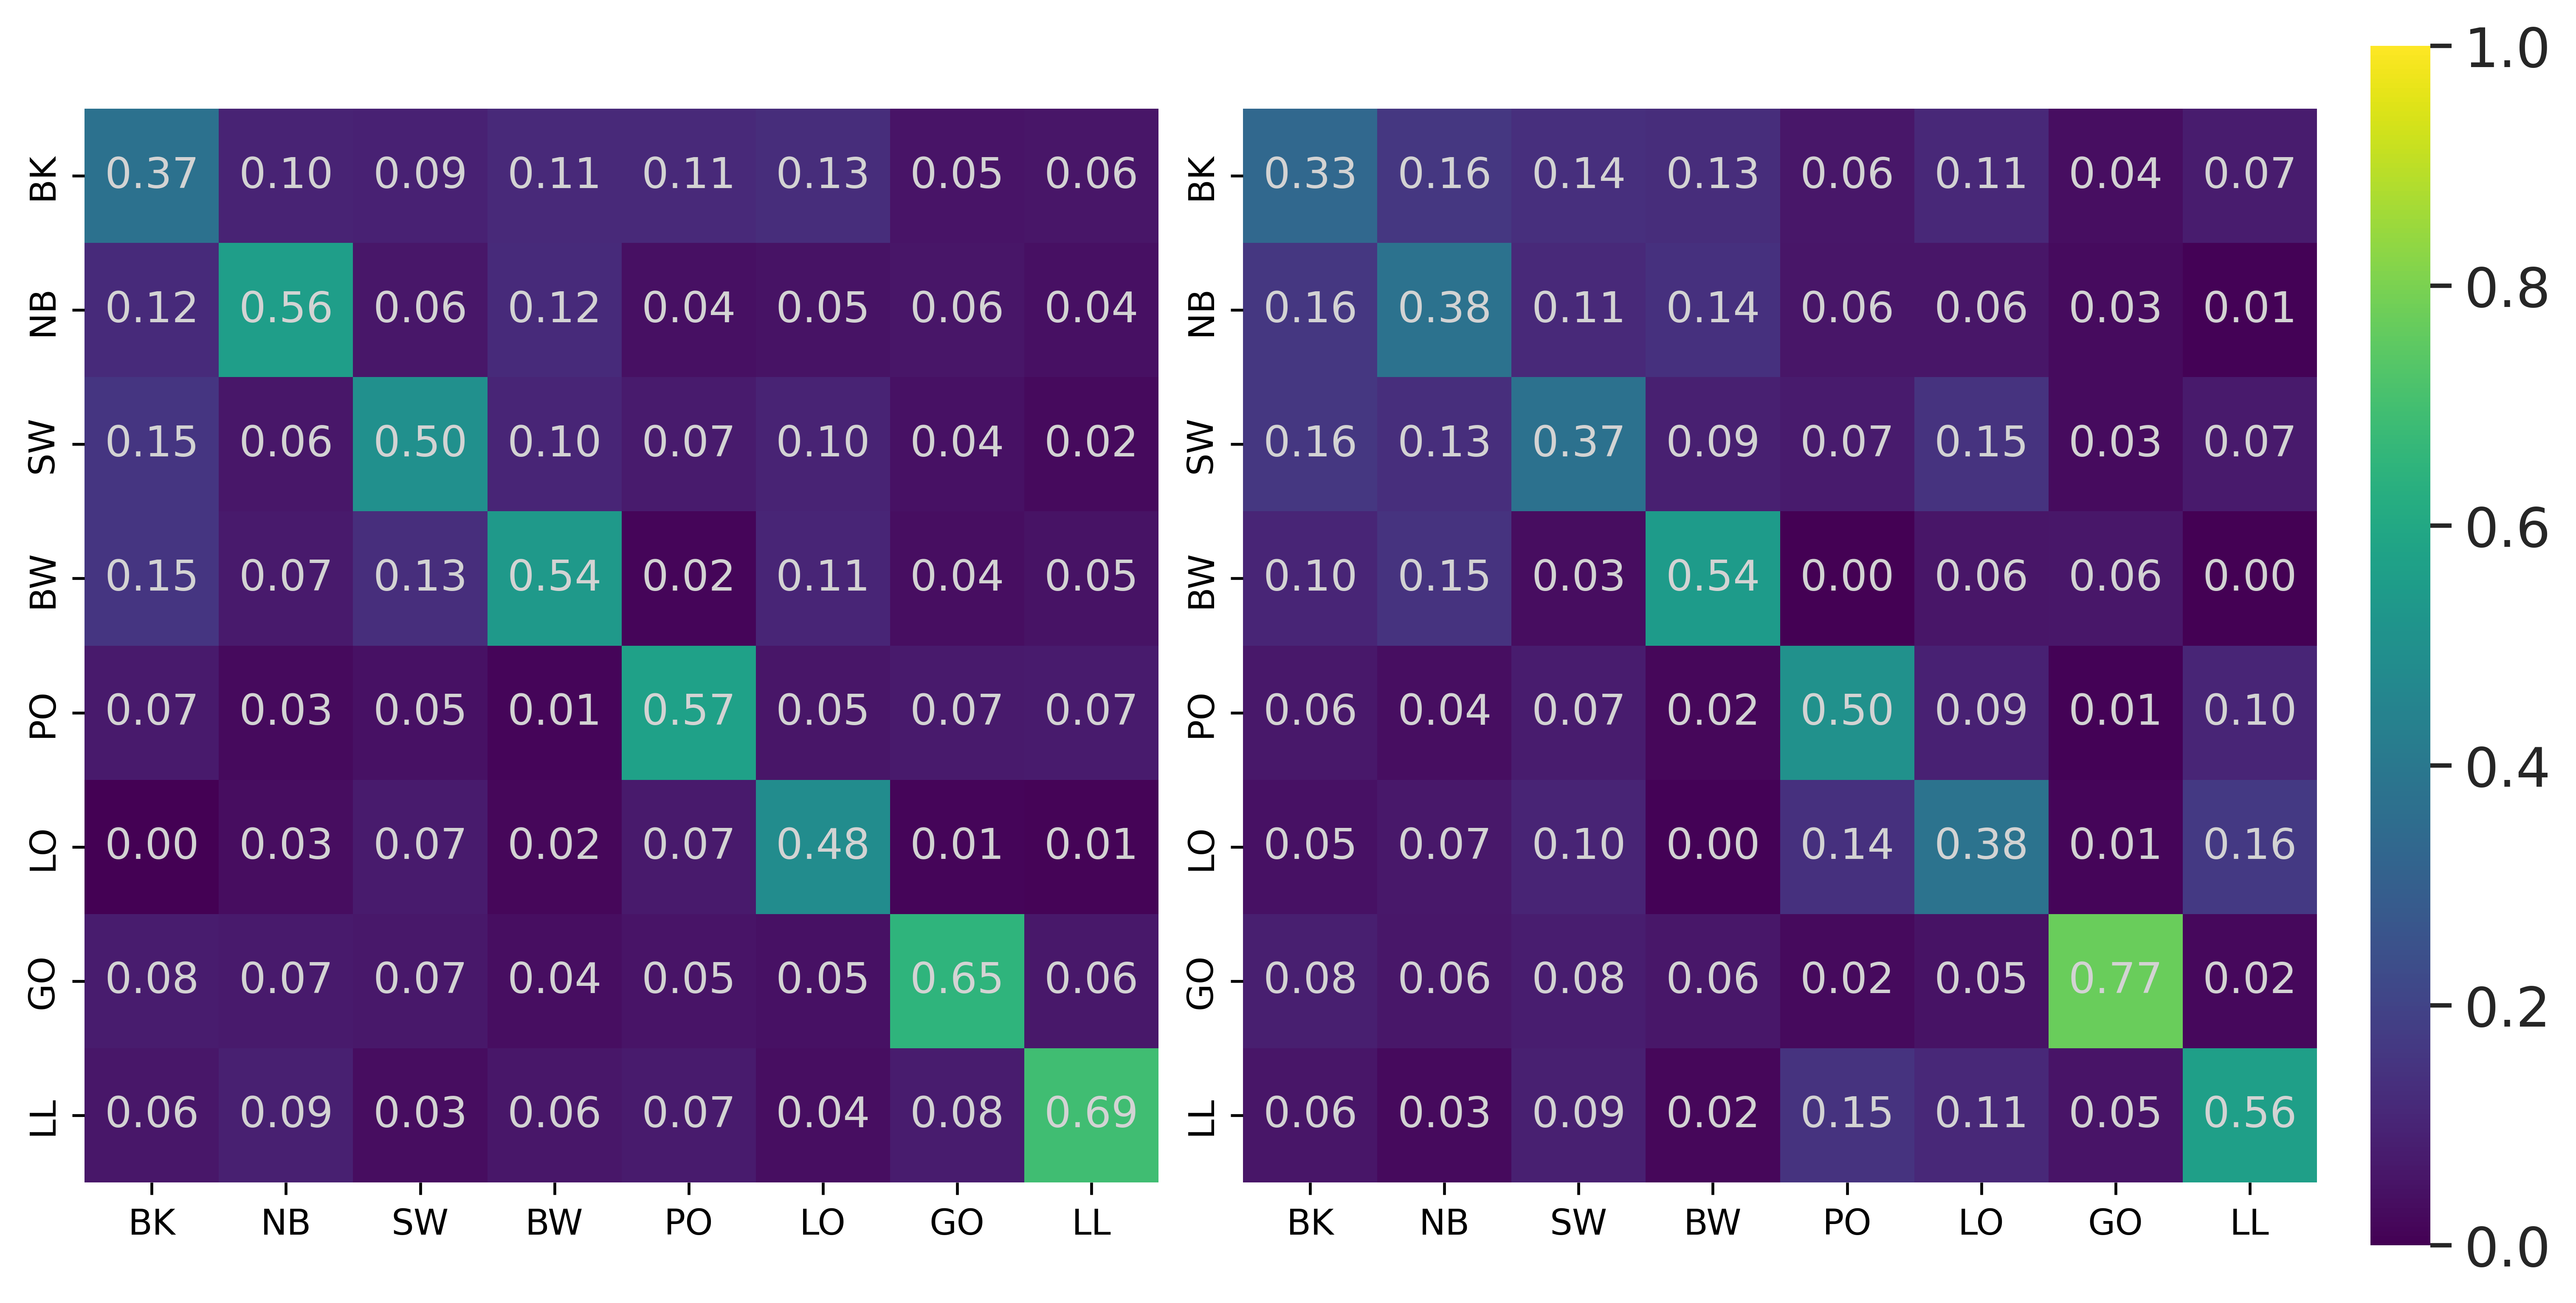

In [25]:
save = False
normalize_over = 'columns'

cry_model = pickle.load(open('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230207_062140/random_forest_20230207_062140_model_cry.pkl', 'rb'))
USV_model = pickle.load(open('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230207_062014/random_forest_20230207_062014_model_USV.pkl', 'rb'))

###################################################################################################################

#Evaluate
labels = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL']
cry_y_pred = cry_model.predict(cry_X_test)
USV_y_pred = USV_model.predict(USV_X_test)

#set up the axes for plot
fig, axes = plt.subplots(nrows = 1, 
                         ncols = 2, 
                         figsize = [10,5], 
                         constrained_layout=True, 
                         dpi=600)

if normalize_over == 'rows':
    cry_cm = confusion_matrix(cry_y_test,cry_y_pred, labels = labels, normalize = 'true')
    USV_cm = confusion_matrix(USV_y_test,USV_y_pred, labels = labels, normalize = 'true')
    
elif normalize_over == 'columns':
    cry_cm = confusion_matrix(cry_y_test,cry_y_pred, labels = labels, normalize = 'pred')
    USV_cm = confusion_matrix(USV_y_test,USV_y_pred, labels = labels, normalize = 'pred')
    

#normalize by row sum
cry_cm_df = pd.DataFrame(cry_cm, columns=labels, index=labels)
#cry_cm_df = cry_cm_df.div(cry_cm_df.sum(axis=0), axis=1)

USV_cm_df = pd.DataFrame(USV_cm, columns=labels, index=labels)
#USV_cm_df = USV_cm_df.div(USV_cm_df.sum(axis=0), axis=1)

sns.set(font_scale=1.4) # for label size

#plot cry confusion matrix
sns.heatmap(cry_cm_df, 
            annot=True, 
            annot_kws={"size": 12, "color":'lightgrey'}, 
            fmt=".2f",
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True, 
            ax = axes[0], 
            cbar=False) 

#plot USV confusion matrix
sns.heatmap(USV_cm_df, 
            annot=True, 
            annot_kws={"size": 12, "color":'lightgrey'}, 
            fmt=".2f",
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True, 
            ax = axes[1], 
            cbar=True) 

cry_report = classification_report(cry_y_test, cry_y_pred, output_dict=True)
USV_report = classification_report(USV_y_test, USV_y_pred, output_dict=True)

if save:
    plt.savefig('', dpi=600)
    plt.savefig('')


## train model to predict species from varying amounts of training examples

In [15]:
#evaluate machine learning models trained on varying amounts of data

#features for prediction
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
features_for_training = params_dict['figure_2_panels_AB']['features']

#species
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']

#sample sizes to train on for each species
sample_sizes = [20, 40, 200, 400, 600, 800, 1000, 1200, 1400]

random_state = 123456

print('cry')
cry_prediction_df = machinelearning.get_metric_by_sample_size(
                                                              voc_type = 'cry', 
                                                              voc_df = annotations_df_not_clipped, 
                                                              sample_sizes = sample_sizes,
                                                              features = features_for_training, 
                                                              random_state = random_state, 
                                                              test_size = 0.2, 
                                                              target ='species', 
                                                              n_estimators = 100)
print('USV')
USV_prediction_df = machinelearning.get_metric_by_sample_size(
                                                              voc_type = 'USV',
                                                              voc_df = annotations_df_not_clipped, 
                                                              sample_sizes = sample_sizes,
                                                              features = features_for_training, 
                                                              random_state = random_state, 
                                                              test_size = 0.2, 
                                                              target ='species', 
                                                              n_estimators = 100)

evaluation_df = pd.concat([cry_prediction_df, USV_prediction_df])

print('done.')

In [148]:
evaluation_df = evaluation_df.rename(columns={'f1-score':'f1score'})

In [151]:
save_path = ''
save_name = 'figure_2B_data.csv'
evaluation_df.to_csv(os.path.join(save_path, save_name), index=False)

## plot colored by vocalization type (Figure 2 Panel B)

In [16]:
save=False

############################################################################################################

save_dir = ''
version = '20230207'
metric = 'precision'

############################################################################################################

ytick_length = 2
ytick_pad = 0.5
fontsize=9

voc_name_color_dict = {'cry': 'deeppink', 
               'USV': 'thistle'}

sns.set_style("whitegrid", {'axes.grid' : False})
species_color_dict = {'BW':'darkblue',
              'NB': 'dodgerblue',
              'BK': 'steelblue',
              'SW': 'blue',
              'PO': 'orange',
              'LO': 'goldenrod',
              'GO': 'green',
              'LL': 'forestgreen',
              'MU': 'mediumspringgreen', 
              'MZ': 'turquoise'}

fig, ax = plt.subplots(ncols=1, 
                       nrows=1, 
                       constrained_layout=True, 
                       sharey=False, figsize = [4,2], dpi=600)


model_df = evaluation_df.loc[evaluation_df['species'].isin(species_list)]
model_df = evaluation_df.reset_index(drop=True)


sns.stripplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df,
                     jitter=False,
                     dodge=True,
                     hue='voc_type', 
                     palette=voc_name_color_dict, 
                     ax=ax, alpha=.75, s=5)

sns.boxplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df, 
                     hue='voc_type',
                dodge=True,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .1, "color":'black', 'alpha':0},
                whiskerprops={"linewidth": .1, "color":'black', 'alpha':0},
                width = .5, 
                showcaps=False,
                ax=ax)




ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([0,1])
ax.legend([],[], frameon=False)

ax.xaxis.set_tick_params(width=.5, rotation = 90, length = ytick_length, pad = ytick_pad)
ax.yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

ax.set_yticks([0,.2, .4, .6, .8, 1])
ax.set_ylim([0,1])
ax.axhline(y=(1/8), linestyle= 'dashed', color='black', linewidth=0.5)


for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(.5)
for label in (ax.get_yticklabels() + ax.get_xticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(fontsize)

sns.despine()

if save:
    save_name = ('_').join([metric, 'by_sample_size', version])
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    

## Figure 2 panel B statistics

In [22]:
library(lme4)

fig2B_data_path <- ""
fig2B <- read.csv(fig2B_data_path)
fig2B <- subset(fig2B, species != "accuracy" & species != "macro avg" & species != "weighted avg")


#mixed effect model
rf.model <- lm(precision ~ sample_size + voc_type + species, data = fig2B)
summary(rf.model)
TukeyHSD(rf.model)

# Train a model to predict vocalization type (cry, USV, or nonvocal) from features

## downsample

In [11]:
#get the sampling parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
seed = params_dict['supp_figure_3']['sampling_seed']
num_to_sample = params_dict['supp_figure_3']['num_to_sample']

#sample
print('sampling...')
ds_df = annotation.sample(seed, num_to_sample, annotations_df)

print('done.')

## add the annotated nonvocal sounds

In [79]:
#get annotated scratch sounds
features_for_training = params_dict['supp_figure_3']['features']
nonvocal_df = pd.read_csv(annotations_nonvocal)
nonvocal_df['human_label'] = [i.split('_')[0] for i in nonvocal_df['source_file']]
nonvocal_df_scratch = nonvocal_df.loc[nonvocal_df['human_label'] == 'scratch']
nonvocal_df_scratch['species'] = [i.split('_')[1] for i in nonvocal_df_scratch['source_file']]
nonvocal_df_scratch = nonvocal_df_scratch[features_for_training+['source_file','species', 'human_label']]

#merge with vocalizations
ds_df = ds_df.drop(columns = ['umap1', 'umap2', 'hdbscan_label', 'removal_flag'])
assert sorted(nonvocal_df_scratch.columns) == sorted(ds_df.columns)
ds_df = pd.concat([ds_df, nonvocal_df_scratch]).reset_index(drop=True)

#make sure you have all of the labels
assert set(ds_df['human_label'].unique()) == set(['cry', 'USV', 'scratch'])

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
#show annotations by species 
print('annotations by species:\n')
for i in species_list:
    print(i,':', len(ds_df.loc[ds_df['species'] == i]))
    
# show annotations by label
print('\n')
print('annotations by label:\n')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('USV:', len(ds_df.loc[ds_df['human_label'] == 'USV']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))

In [53]:
#ds_df.to_csv('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/resubmission/figure_2/supplemental_figure_3_data.csv', index=False)


## select the features

In [44]:
#features for prediction
features_for_training = params_dict['supp_figure_3']['features']

#features and labels for training
features_targets = ds_df

## check for missing data and make sure there are no duplicates

In [13]:
assert features_targets[features_for_training].isnull().values.any() == False
print('No missing data')
    
assert features_targets.duplicated(subset=['source_file']).sum() == 0
print('No duplicate data')

## choose the model type and split the data

In [14]:
#get params
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
model_type = params_dict['supp_figure_3']['model_type']
split_random_state = params_dict['supp_figure_3']['split_random_state']
test_size = params_dict['supp_figure_3']['test_size']

#choose the data and the label and convert to numpy array
target = 'human_label'
X = np.array(features_targets[features_for_training])
y = np.array(features_targets[target])

#split the data
print('splitting the data...')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = split_random_state)

print('done.')

## train

In [22]:

#get training params
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
training_random_state = params_dict['supp_figure_3']['training_random_state']
n_estimators = params_dict['supp_figure_3']['training_n_estimators']
criterion = params_dict['supp_figure_3']['training_criterion']
bootstrap = params_dict['supp_figure_3']['training_bootstrap']
oob_score = params_dict['supp_figure_3']['training_oob_score']

#train
print('training...')
voc_type_model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion, 
                                   random_state = training_random_state, 
                                   bootstrap = bootstrap,
                                   oob_score = oob_score)
voc_type_model.fit(X_train, y_train)

#show out of bag score
print(voc_type_model.oob_score_)  
print('done.')

## evaluate (Supplementary Figure 2)

In [24]:
#Evaluate the model on held out data and plot a confusion matrix

save = False

###################################################################################################################

y_pred = voc_type_model.predict(X_test)
labels = ['cry', 'USV', 'scratch']
cm = confusion_matrix(y_test,y_pred, labels = labels, normalize='true')
fig = plt.figure(figsize=[3,3], dpi=600)

# #normalize by row sum
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
# cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, 
            annot=True, 
            annot_kws={"size": 9}, 
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True) # font size

classification_report(y_test, y_pred, output_dict=True)

if save:
    plt.savefig('.jpeg', dpi=600)
    plt.savefig('.svg') 

## save the model

In [25]:
# save model and training params
machinelearning.save(model = voc_type_model,
                     models_root = models_root, 
                     training_df = features_targets, 
                     feature_set = features_for_training, 
                     target = 'voc_type', 
                     test_size = test_size, 
                     n_estimators = n_estimators, 
                     criterion = criterion, 
                     split_random_state = split_random_state,
                     training_random_state = training_random_state,
                     model_type = model_type,
                     bootstrap = bootstrap, 
                     oob_score = voc_type_model.oob_score_)

In [15]:
#load model and training parameters

#model ID
model_ID = '20230203_044016'

#path to model for labeling amplitude segmented vocalizations as cry, scratch or whistle
voc_type_model_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_voc_type_model.pkl')
voc_type_params_path = os.path.join(models_root,'voc_type_classifiers', model_ID, 'random_forest_'+model_ID+'_params')

#load the model
voc_type_model = pickle.load(open(voc_type_model_path, 'rb'))

#load the training parameters
voc_type_params = parameters.load(save_dir=os.path.split(voc_type_params_path)[0], 
                                  save_name=os.path.split(voc_type_params_path)[1])


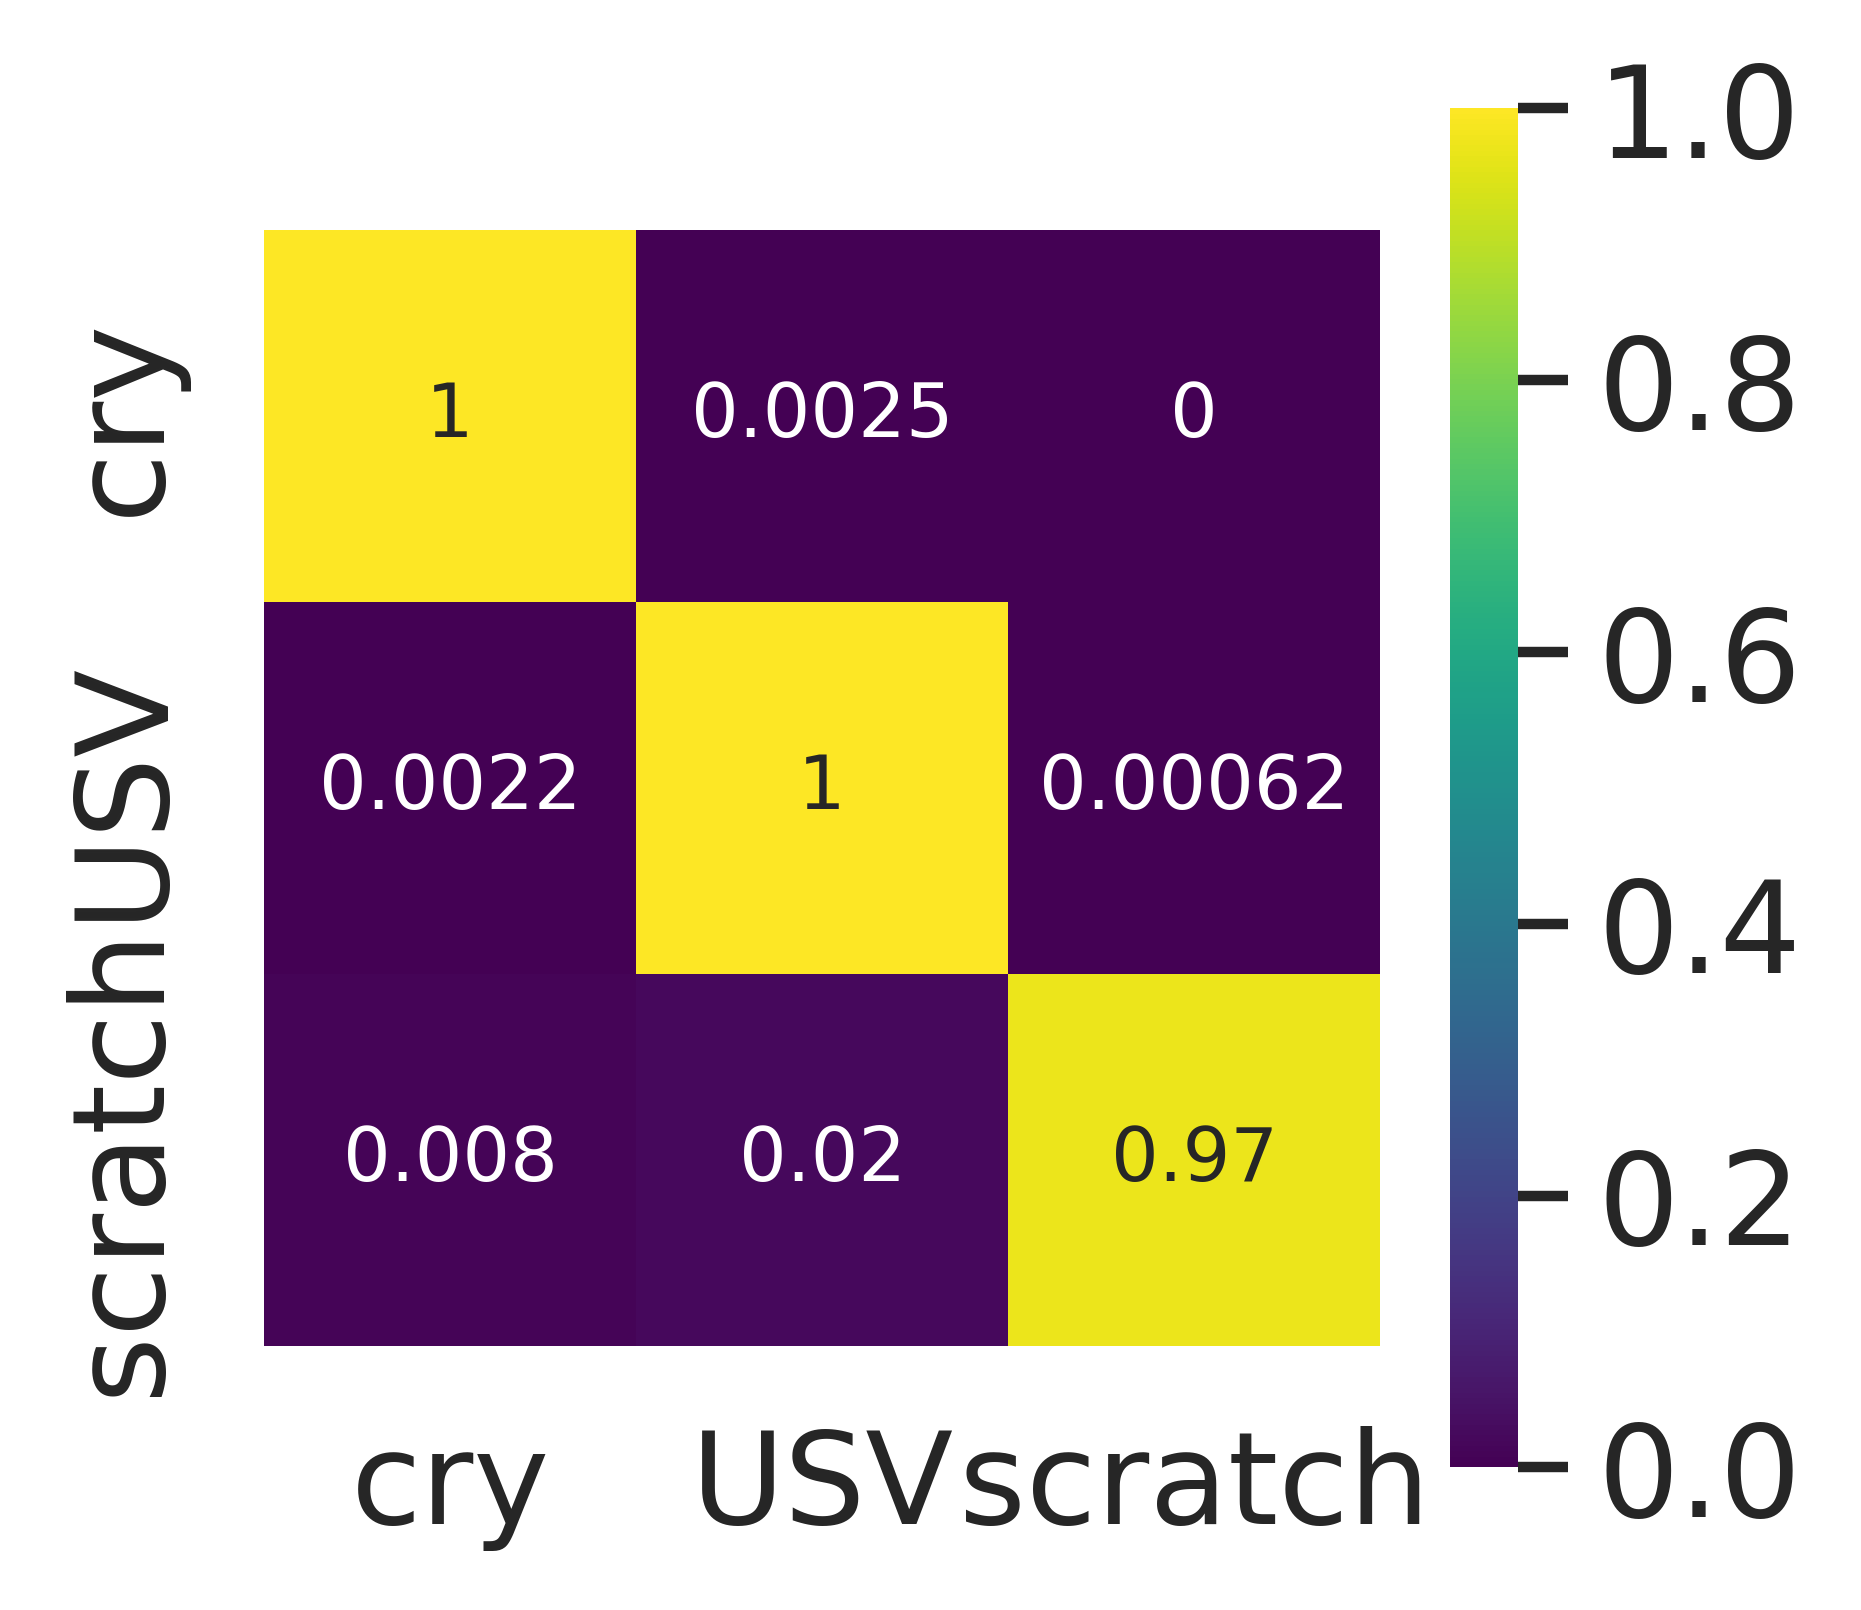

In [48]:
#Evaluate the model on held out data and plot a confusion matrix

save = False

###################################################################################################################

y_pred = voc_type_model.predict(X_test)
labels = ['cry', 'USV', 'scratch']
cm = confusion_matrix(y_test,y_pred, labels = labels, normalize='true')
fig = plt.figure(figsize=[3,3], dpi=600)

# #normalize by row sum
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
# cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, 
            annot=True, 
            annot_kws={"size": 9}, 
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True) # font size

classification_report(y_test, y_pred, output_dict=True)

if save:
    plt.savefig('.jpeg', dpi=600)
    plt.savefig('.svg') 